# Deep Learning Programming Ex 01: Softmax Regression

In this exercise you will:

- Build the general architecture of a softmax regression algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent)
- Gather all three functions above into a main model function, in the right order.

Instructions:

- Read the comments carefully and run each cell (in the right order)
- Implement the missing code

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import time
import sys

## CIFAR-10 visualization [0pt]

Run the next cell to display a grid of example images.
This ensures you can load the dataset - may take a few seconds to print

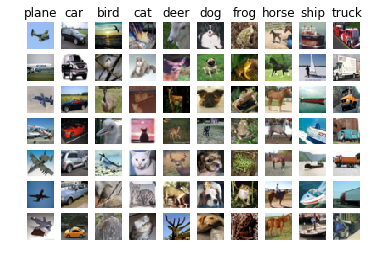

In [2]:
# Load the raw CIFAR-10 data.

cifar10_dir = '../../data/cifar/'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## CIFAR-10 load data [0pt]

Run the next cell to define a data helper function that does some basic preprocessing.

In [4]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../../data/cifar'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    # these are numpy arrays, not lists - that's why this indexing works.
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Task 1: Softmax - Loss Function and Gradients [5pt]

Complete the implementation of softmax_loss_naive and implement a (naive) version of the (analytical) gradient descent that uses nested loops.

In [163]:
def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes,
    and we operate on minibatches of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    
    num_classes = W.shape[1]
    num_samples = X.shape[0] #: #of training samples passed in batch X
    

    #############################################################################
    # Compute the softmax loss and its gradient using explicit loops.           #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    
    for i in range(num_samples):
        scores = X[i].dot(W)
        scores -= np.max(scores)

        exp_sums = np.sum(np.exp(scores - scores.max()))
        p = lambda k: np.exp(scores[k]) / exp_sums
        loss += -np.log(p(y[i]))

    
        for k in range(num_classes):
            p_k = p(k)
            dW[:, k] += (p_k - (k == y[i])) * X[i]
    
    
    loss /= num_samples
    loss += 0.5 * reg * np.sum(W * W)
    dW /= num_samples
    dW += reg * W
    
    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################
    return loss, dW


## Check: Gradients [0pt]

The next cell is a self-check for you to make sure your softmax implementation works!
It compares your analytical gradients to numerically calculated gradients.
The numerical and analytical values should be the same up to printing accurracy,
relative error should be smaller than $10^{-7}$.

In [164]:
# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001 
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 2.105544,	analytic: 2.105544,	relative error: 3.066903e-08
numerical: 0.351344,	analytic: 0.351344,	relative error: 5.574761e-08
numerical: 0.751882,	analytic: 0.751882,	relative error: 4.923070e-08
numerical: 4.669270,	analytic: 4.669270,	relative error: 3.143437e-09
numerical: -1.711867,	analytic: -1.711867,	relative error: 1.648966e-09
numerical: 0.634681,	analytic: 0.634681,	relative error: 2.085663e-08
numerical: -0.061480,	analytic: -0.061480,	relative error: 3.717803e-07
numerical: -4.280979,	analytic: -4.280979,	relative error: 1.535648e-09
numerical: -1.420748,	analytic: -1.420748,	relative error: 3.334900e-08
numerical: -4.045274,	analytic: -4.045274,	relative error: 5.601274e-09
numerical: 0.777766,	analytic: 0.777766,	relative error: 1.065786e-08
numerical: -1.464152,	analytic: -1.464152,	relative error: 8.177550e-09
numerical: -0.471700,	analytic: -0.471700,	relative error: 3.889312e-08
numerical: 5.669851,	analytic: 5.669851,	relative error: 1.268740e-09
numeri

# Task 2: Softmax-  Loss Function & Gradients - Vectorized [5pt]

Implement a vectorized version of the previous function.

In [165]:
def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.
    Inputs have dimension D, there are C classes,
    and we operate on minibatches of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
  
  

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)
    
    num_samples = X.shape[0]
    #############################################################################
    # Compute the softmax loss and its gradient using no explicit loops.        #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################

    scores = X.dot(W)
    scores -= np.max(scores, axis=1, keepdims=True)
    exp_scores = np.sum(np.exp(scores), axis=1, keepdims=True)
    p = np.exp(scores)/exp_scores

    loss = np.sum(-np.log(p[np.arange(num_samples), y]))
    
    ind = np.zeros_like(p)
    ind[np.arange(num_samples), y] = 1
    
    dW = X.T.dot(p - ind)

    #############################################################################
    #                          END OF YOUR CODE                                 #
    #############################################################################

    return loss, dW

# Check: Performance Comparison: [0pt]

Execute the cell below to run a performance comparison between the naive implementation using loops
and the optimized version using vectorized instructions.
The two versions should compute the same results, but the vectorized version should be much faster.

In [166]:
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff = tic - toc
print('Naive loss: %e computed in %fs' % (loss_naive, diff))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
diff_vec = tic - toc
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, diff_vec))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)
print('Runtime abs. difference: %f seconds' % (diff_vec - diff))
print('Runtime rel. improvement: %f percent' % (1 - (diff_vec / diff)))

Naive loss: 2.409210e+00 computed in -0.188881s
Vectorized loss: 1.204605e+03 computed in -0.004001s
Loss difference: 1202.195746
Gradient difference: 173916.217259
Runtime abs. difference: 0.184880 seconds
Runtime rel. improvement: 0.978815 percent


# Task 3: Softmax - Stochastic Gradient Descent [5pt]

In the cell below, you have to utilize your previously implemented vectorized gradient function
to train a softmax classifier.

In [167]:
def train_SGD(X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    W: A numpy array of shape (D, C) containing weights
    loss_history: A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
   
    # Generate a random softmax weight matrix 
    W = 0.001 * np.random.randn(dim, num_classes)

    # Run stochastic gradient descent to optimize W
    loss_history = []
    for it in range(num_iters):
        X_batch = None
        y_batch = None

        #########################################################################
        # TODO:                                                                 #
        # Sample batch_size elements from the training data and their           #
        # corresponding labels to use in this round of gradient descent.        #
        # Store the data in X_batch and their corresponding labels in           #
        # y_batch; after sampling X_batch should have shape (dim, batch_size)   #
        # and y_batch should have shape (batch_size,)                           #
        #                                                                       #
        # Hint: Use np.random.choice to generate indices. Sampling with         #
        # replacement is faster than sampling without replacement.              #
        #########################################################################

        
        #########################################################################
        #                       END OF YOUR CODE                                #
        #########################################################################

        # evaluate loss and gradient
        loss, grad = softmax_loss_vectorized(W, X_batch, y_batch, reg)
        loss_history.append(loss)

        # perform parameter update
        #########################################################################
        # TODO:                                                                 #
        # Update the weights using the gradient and the learning rate.          #
        #########################################################################

        
        
        #########################################################################
        #                       END OF YOUR CODE                                #
        #########################################################################

        if verbose and it % 100 == 0:
            print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return W, loss_history

# Task 4: Softmax - Predictor Function [5pt]

In the next cell, you have to implement a function that predicts classes given a trained classifier and a
batch of data points.

In [168]:
def predict(W, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################

    
    
    ###########################################################################
    #                           END OF YOUR CODE                              #
    ###########################################################################
    return y_pred

# Check: Predictor Accuracy [0pt]

If your code is correct, the next cell will give you an accuracy of about 33%

In [169]:
W, loss_hist = train_SGD(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=2500,
            batch_size=200, verbose=True)
y_train_pred = predict(W,X_train)
train_acc = np.mean(y_train == y_train_pred)
print("training accuracy: "+ str(train_acc))

AttributeError: 'NoneType' object has no attribute 'shape'

# Task 5: Softmax - Hyperparameter Tuning [5pt]

Now let's put all function together and find the optimal hyperparameters 
(regularization strength and learning rate) using the validation set.
You should experiment with different ranges for the learning
rates and regularization strengths; if you are careful you should be able to
get a classification accuracy of over 0.35 on the validation set.

In [170]:
results = {}
best_val = -1
best_W = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# the best trained softmax classifer in best_W.                                #
################################################################################



################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best validation accuracy achieved during cross-validation: -1.000000


# Check: Prediction on Test Set [0pt]

Check your models capabilities on unseen test data!

In [171]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = predict(best_W,X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.103000
